# Project: Periodic Table 
#### Paul Tan

## Abstract
I set out to use machine learning techniques to both classify elements in the Periodic table and regress periodic properties to atomic number. The dataset used contains the Atomic Mass, Electronegativity, Atomic Radius, Ionization Energy, Electorn Affinity, Melting Point, Boiling Point, and (Room Temperature) Density data. Since the data set is very small, with 78 measurements used in classifying, and 118 measurements used in regression, the goal here is to make predictions which are meaningful and not simple overfits to the small training data. I classify elements by their period and demonstrate that, not surprisingly, without atomic number and atomic mass, models struggle to classify by period. Next, an LSTM model is used to predict ionization energies of the 5th and 6th period by training on data from periods 2-4.

## Motivation
A neural network is trained to predict the period off an element based off of numerical features: Atomic Mass, Electronegativity, Atomic Radius, Ionization Energy, Electorn Affinity, Melting Point, Boiling Point, and Density data. The trained model itself has little practical use. The learning goal here is to understand what the model is learning, by using dimensionality reduction techniques to analyze the output layers, and investigate potential atomic features which are crucial to classification. Indeed, we find that much of the numerical data is unnecesary; 100% accurate classification is achieved when using just the atomic mass and the ionization. Furthermore, the atomic mass, as expected, since it correlates directly to the atomic number, is the most valuable classification feature. Without atomic mass, the model struggles to classify elements into periods. However, it is possible to train a fairly accurate model which classifies based on all feature exclusing the atomic mass. The neural architecture used to train said model was not robust, and was heavily dependent on the stochastic initialization of parametres and the gradient descent, which produced varying validation accuries. For a test sample of 21 elements, with a training size of 50 elements, the best model misclassified 4 elements. I have highlighted here some of the outcomes, to demonstrate how I have learnt which features are important in classifying elements.

An LSTM model was also used to predict the ionization energy of the 5th and 6th periods based on data from periods 2-4. What I will most highlight about this model is how unrobust the training was. Even with the final neural architecture which produced strong validation results, the validation results varied signifigantly as the initialization of the model was changed, and as the model was further trained and overfitted. The learning I take away from training this model focuses on the way the model trains, and what the model is actually learning about the input data. Here the focus was on avoiding overfitting the data. 



## Dataset
- Before I visualise the data I will mention where the data comes from. The dataset is public, from the PubChem period table website: https://pubchem.ncbi.nlm.nih.gov/periodic-table/. The data comes from sources including International Union of Pure and Applied Chemistry (IUPAC), National Institute of Standard and Technology (NIST), International Atomic Energy Agency (IAEA), Jefferson Laboratory, and Los Alamos National Lab. These are experimental results. However, there were missing data points for some atomic numbers above 100, the first ionization energies data for these atoms was taken from NIST at https://physics.nist.gov/PhysRefData/ASD/ionEnergy.html.

- In processing the data, I normalized each feature. This was done to improve the training rate, since the weights would not have to learn any information related to scale. Throughout, I discuss and plot results in their normalized form, although the predictions of the models can easily be mapped to results in the appropriate units.

- For the classification model, the lanthanoid series was not considered, and the model was trained using elements with atomic number from 3 to 56 and 71 to 86. Hydrogen and Helium were removed from the dataset. The reason for this was that the sample size of their period, 2, is too small. If we manually choose the training set to contain 1 of the elements, the decision boundary that the model will learn based upon that datapoint is largely arbitrary. I noticed this also after visualizing some of the decision boundaries when these elements were included.
- For the regression model, the periods 2-6 were used in the dataset. Removing the first period makes the learning task simpler; I was unable to produce a succesful model which contained hydrogen and helium - although I spent less time using these elements in the training dataset. Includign these elements increased the complexity of the training series, as we will see later. I scaled the data differently for this model. The range of the data was scaled to be bewteen -1 and 1, the results were found to converge faster with this rescaling.
- For labels, the period is number from 1-6.
- Below I have plotted the features against atomic number, the units for each feature are arbitrary.

In [299]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

from sklearn.manifold import TSNE

In [351]:
# Data Processing

file = pd.read_csv("PubChemElements_all.csv")

data = np.array(file)

# Extracting only numerical features.
X1 = np.array([data.T[3],data.T[6],data.T[7],data.T[8],data.T[9],data.T[12],data.T[13],data.T[14]])

titles = ["Atomic Mass","Electronegativity","Atomic Radius","Ionization Energy","Electron Affinity","Melting Point","Boiling Point","Density"]


# Here I have normalized the data. 
X = np.array(([list(map(np.nan_to_num,x))/np.sum(list(map(np.nan_to_num,x))) for x in X1])).T
# Here I remove the Lanthanoid series for the purpose of the classifying exercise 
X_small = np.concatenate((X[:56],X[71:86]))

# Here I define the period as a label for each datapoint
labels = np.concatenate((file["Period"][:56],file["Period"][71:86]))



Text(0.5, 0, 'Atomic Number')

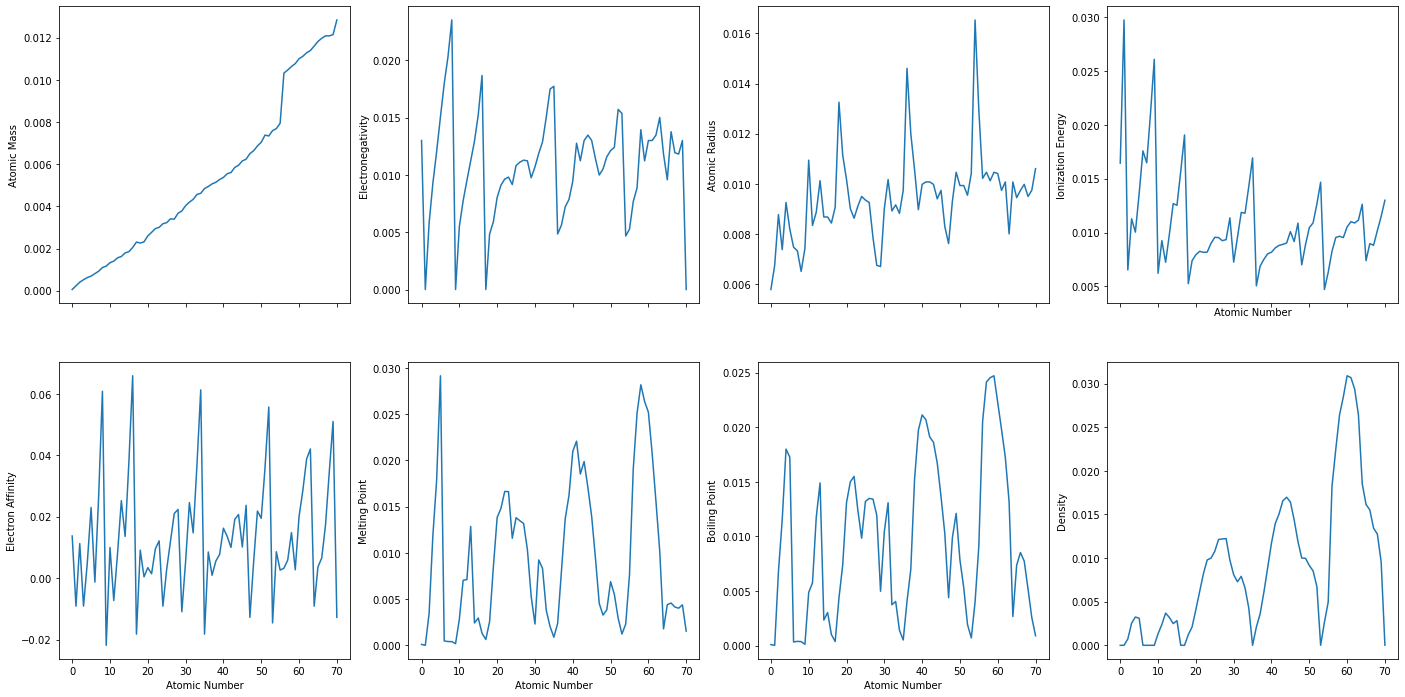

In [348]:
fig1, ax1 = plt.subplots(2,4,figsize=(24,12),sharex = True)
for i in range(4):
    ax1[0,i].plot(X_small[:,i])
    ax1[0,i].set_ylabel(titles[i])
    
for i in range(4):
    ax1[1,i].plot(X_small[:,i+4])
    ax1[1,i].set_ylabel(titles[i+4])
    
ax1[1,3].set_xlabel("Atomic Number")
ax1[1,2].set_xlabel("Atomic Number")
ax1[1,1].set_xlabel("Atomic Number")
ax1[1,0].set_xlabel("Atomic Number")

## Model, Training and Validation

I have included validation discussion into the model training to save on word count.

All the models discussed in the classification section are models which are trained to predict the period to which an element belongs by looking at its elemental properties. 

The regression model is a model which learns to predict the ionization energy of the 5ths and 6th periods by looking only at the previous 3 periods. The machine learning technique used to make these predictions is one which is well suited to time series data; this model practises a form of predicting 'future' information based on past data. 


### Classification Model Using All Features
- I began by classifying using all available features (for the readers sake, I wont list all the features again). I used a random training and test split; this was done because I wanted to be able to vary the validation sample size as a hyperparameter to understand how much data the model needs to train.
- The model used was a neural network with 3 dense hidden layers, with 32,64 and 64 neurons each. The activation function used was a relu. For this model, picking hyperparameters was not the focus; I chose a sufficiently complex model, compromising on training time. As I will later demonstrate, the results show that the accuracy of the validation and test data plateaues, there is not a tendency to overfit to the data in a way which compromises on validation accuracy, for this model. Since overfitting was not an issue, I did not attempt to optimize hyperparameters or add regularization terms.
- I used a cross entropy loss function, as is fitting to a classification problem with mutiple labels. In the code, the loss function is defined as the sparse cross entropy, this is a tensor flow implementation of the cross entropy which is used when the labels are provided as integers: the labels I provided was the period number, for this reason the sparse cross entropy fitted this model.
- I did not apply any activation to the final output layer. Instead, the cross entropy loss function applied the softmax activation in the calculation of the loss. The reason I did this was so that I could observe the features that the model was learning in the final layer. I plotted the final layer outputs as a way of visualising the final results. Using TSNE to visualise the final layer outputs helped me see if the model was succesfuly creating class clusters; I used these plots to guide choices of hyper parameters, as well as to guide which features were used to train. 
- The adam optimizer was used to perform gradient descent. I found that using the adam operator, the inclusion of a momentum term to 'escape' local minima was necessary. I found that the models converged much faster when a momentum term was included, without it, the model training tended to become stuck in local minima in the loss function.
#### I first show how the training and validation loss change with respect the the validation sample proportion
##### Summary for the following code: The model is able to train fairly well, with accuracy averaging 80% using only 50% of the available data, which is only 35 data points. We will see later, however, that the model overfits to all 8 features, when only 2 features are necessary. Furthermore, it is worth noting that the accuracy of the validation does not tend to increase past 1000 training iterations (epochs). 

##### The model overfits to the training data, as is evident in the training and validation cross entropy loss plots shown below the prediction accuracy plots.

In [ ]:
# Train multiple models with different random validation subsetting.
# Randomly initializing the weights each time.
N = 5
N2 = 3

test_sizes = [0.3,0.4,0.5]

models = [0]*N*N2
for j in range(N2):
    for i in range(N):
        # Re-initializing model weights each time (this is likely a crude way)
        
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(32,input_shape=((8,)),activation = 'relu'),
            tf.keras.layers.Dense(64,activation = 'relu'),
            tf.keras.layers.Dense(64,activation = 'relu'),
            tf.keras.layers.Dense(7),
        ])
        model.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),metrics = ['accuracy'],optimizer = "adam")
        
        # Train test split
        X_train, X_test, y_train, y_test = train_test_split(X_small[2:,:], labels[2:], test_size=test_sizes[j], shuffle=True)
        
        # Fitting the model
        models[i+5*j] =model.fit(X_train,y_train,epochs = 1000,verbose = 0,validation_data = (X_test,y_test))




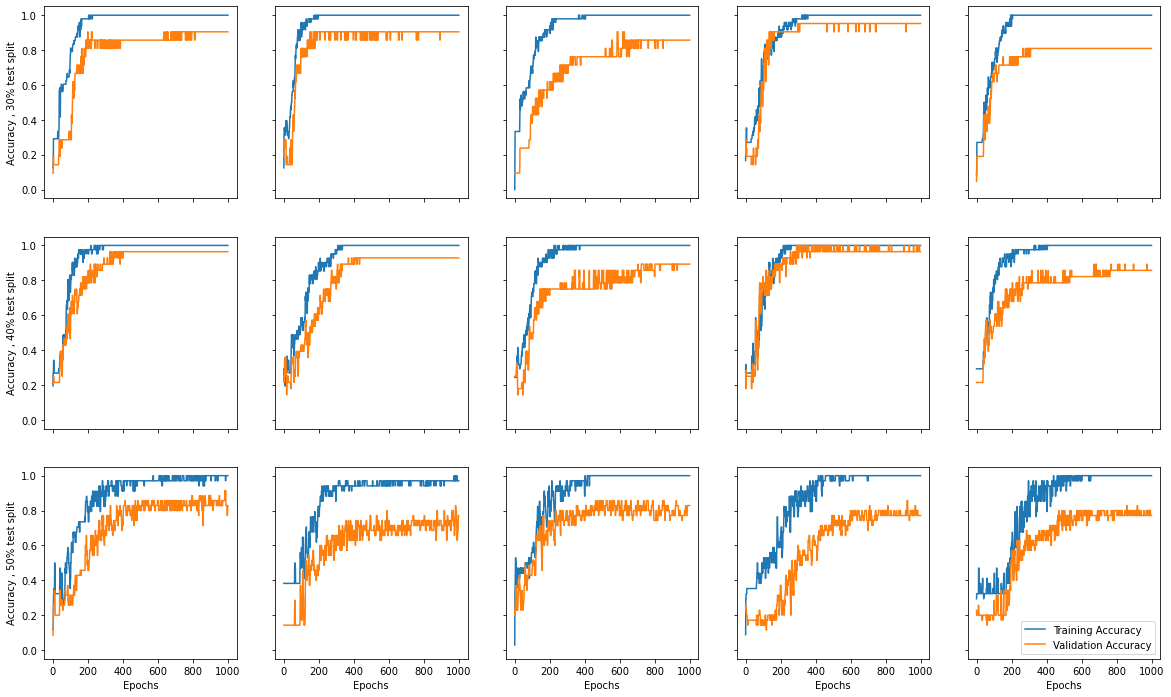

In [77]:
# This block will break if re-run without running the above block which takes a while

fig, ax = plt.subplots(3,N,figsize = (4*N,4*N2),sharey= True,sharex = True)
for j in range(N2):
    for i in range(N):
        ax[j,i].plot(models[i+5*j].history['accuracy'],label = "Training Accuracy")
        ax[j,i].plot(models[i+5*j].history['val_accuracy'],label = "Validation Accuracy")


ax[0,0].set_ylabel("Accuracy , 30% test split")    
ax[1,0].set_ylabel("Accuracy , 40% test split")        
ax[2,0].set_ylabel("Accuracy , 50% test split")        
ax[2,0].set_xlabel("Epochs")   
ax[2,1].set_xlabel("Epochs")        
ax[2,2].set_xlabel("Epochs")        
ax[2,3].set_xlabel("Epochs")        
ax[2,4].set_xlabel("Epochs")        

fig.savefig("Trainings")

plt.legend()
plt.show()


In [368]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,input_shape=((8,)),activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(7),
])
model.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),metrics = ['accuracy'],optimizer = "adam")

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_small[2:,:], labels[2:], test_size=0.3, shuffle=True)

# Fitting the model
model_all_features =model.fit(X_train,y_train,epochs = 1000,verbose = 0,validation_data = (X_test,y_test))

### Classification Using only Atomic Mass and First Ionization Energy
- I trained a model which used only Atomic Mass and First Ionization Energy. Here two hidden layers were used. A less complex model was needed; smaller hidden layers were used, maintaining, however, the relu activations.
- I have found that the model converges consistently. The training accuracy converges to 100% very fast, however decision boundaries continued to be refined as the training loss converges. For this data, both the training and validation loss continue to decreases together, although the validation loss decreases at a slow rate as the iterations increase, there is not a tendency for the model to overfit to the training data at the cost of losing validation accuracy. In this sense, it is clear that in this feature space, which includes only Ionization Energy and Atomic Mass, the classes are well separable. Of course, this should also mean that the data in the higher dimensional feature space which includes all 8 measurements, the classes should also be separable; the 6 other features can be treated as noise. Yet, of course, the model cannot know this. By training a model on this subset of the feature space, we have learnt that the other features cause the model to over fit to what is essentially noise. 
- A natural extension from this step would be to train classification models on different subsets of the data; we would learn then which are the exact features which are causing the model to overfit. From this exercise we have learnt that atomic mass and ionization energy are sufficient. It could also be true that other combinations are sufficient. 
- Finally, it is worth noting that due to the stochasticity of the initialization, the model can be retrained and converges at different rates. It is possible that this model merely converges faster than the above model. 

Text(0.5, 1.0, 'Periods 2-6, Coloured by Period')

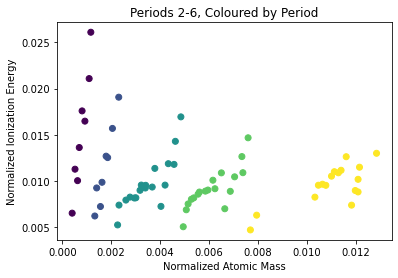

In [378]:
# We can see just by looking that the data is linearly separable. 
# Even a neural network may be overkill. I keep the neural network structure, however,
# for comparison to the other classification attempts.
plt.scatter(X_small[2:,0],X_small[2:,3],c = labels[2:])
plt.xlabel("Normalized Atomic Mass")
plt.ylabel("Normalized Ionization Energy")
plt.title("Periods 2-6, Coloured by Period")

In [369]:
# Model used for classification without atomic mass
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,input_shape=((2,)),activation = 'relu'),
    tf.keras.layers.Dense(32,input_shape=((2,)),activation = 'relu'),
    tf.keras.layers.Dense(7),
])
model.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),metrics = ['accuracy'],optimizer = "adam")

# Here I exclude the atomic mass
X_train, X_test, y_train, y_test = train_test_split(X_small[2:,[0,3]], labels[2:], test_size=0.3, shuffle=True)

In [359]:
model.load_weights("Ionization_Energy_Atomic_Mass")   

In [ ]:
# Train 
# The model has converged every time I train, although somtimes I have needed to increase the number of epochs.
store_model = model.fit(X_train,y_train,epochs = 7000,verbose = 0,validation_data = (X_test,y_test))


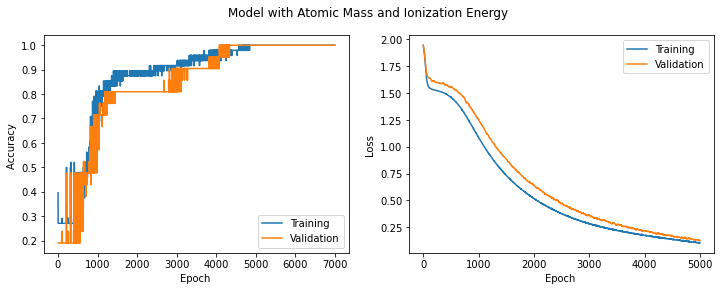

In [372]:
# Plot


fig2 ,ax2 = plt.subplots(1,2,figsize = (12,4))
fig2.suptitle("Model with Atomic Mass and Ionization Energy")

ax2[0].plot(store_model.history['accuracy'][:7000],label = "Training")
ax2[0].plot(store_model.history['val_accuracy'][:7000],label="Validation")
ax2[0].set_ylabel("Accuracy ")
ax2[0].set_xlabel("Epoch ")
ax2[0].legend()


ax2[1].plot(store_model.history['loss'][:5000],label = "Training")
ax2[1].plot(store_model.history['val_loss'][:5000],label = "Validation")
ax2[1].set_ylabel("Loss ")
ax2[1].set_xlabel("Epoch ")
ax2[1].legend()


### Classification without Atomic Mass using all other features

- I used the exact same architecture and trained the moedl on data without atomic mass.
- Here I summarise the results with four images which are representative of the results. On the x axis of each are the number of iterations. On the y axis is loss, or accuracy, as indicated by the title. 

![Validation One](./without_AtomicMass_1.png)
![Validation Two](./without_AtomicMass_2.png)
![Validation Three](./without_AtomicMass_3.png)
![Validation Four](./without_AtomicMass_4.png)

- It is clear that the model overfits to the training data and fails to accurately predict the period. 
- The take away here is that atomic mass is an essential parameter. Of course, this is no surprise, as the atomic mass correlates well with atomic number, which essentially defines the physics of an atom. 
- That said, I do not discount the results which achieve 80% accuracy. For a test size of 21, this ment only 4 elements were mislabelled. Given the importance of atomic number in defining the properties of an element, that the period of an element can be predicted with 80% accuracy without knowledge of the atomic mass is a worthwhile result. I did not continue to train these models which achieve 80% accuracy, as the validation cross entropy loss was clearly not increasing; the model would likely continue to overfit to the training data and result in a decrease in validation accuracy.
- From the plots below, we can see the model struggles to separate between the classes.

In [391]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32,input_shape=((7,)),activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(64,activation = 'relu'),
    tf.keras.layers.Dense(7),
])
model.compile(loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),metrics = ['accuracy'],optimizer = "adam")

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_small[2:,1:], labels[2:], test_size=test_sizes[j], shuffle=True)

# Fitting the model
model_not_mass = model.fit(X_train,y_train,epochs = 1000,verbose = 0,validation_data = (X_test,y_test))

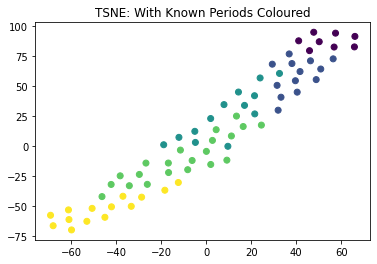

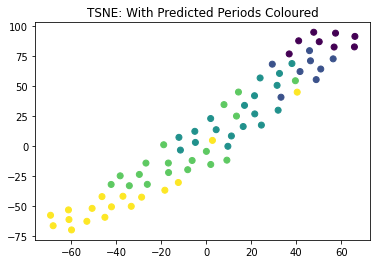

In [395]:
arr1 = model.predict(X_train)
arr2 = model.predict(X_test)
arr3 = model.predict(X_small[2:,1:])

labels_train = [np.argmax(arr1[i]) for i in range(len(X_train))]
labels_test = [np.argmax(arr2[i]) for i in range(len(X_test))]
labels_full = [np.argmax(arr3[i]) for i in range(len(X_small[2:,1:]))]

# Final Layers

X_phi = np.array(model(X_train))
X_test_phi = np.array(model(X_test))
X_small_phi = np.array(model(X_small[2:,1:]))



tsne2 = TSNE(n_components = 2,perplexity = 20).fit_transform(X_small_phi)
plt.scatter(tsne2[:,0],tsne2[:,1],c= labels_full)
plt.title("TSNE: With Known Periods Coloured")
plt.show()


plt.scatter(tsne2[:,0],tsne2[:,1],c= labels[2:])
plt.title("TSNE: With Predicted Periods Coloured")

plt.show()


- We can see clearly that the model struggles to represent the data which lacks atomic mass in a form which is separable.

## Regression: 

- For the regression model, a neural network with LSTM layers was used. One limitation of my exercise here is that I have not gone into detail studying the LSTM model mathematics, so my limited understanding of the cells limits my use of them.
- I first visualise the data which I wish to predict, note that I have scaled the ionization energy to be between -1 and 1. I found this scaling to increase convergence rate with respect to the previously normalized data:

In [398]:
# Atomic Number , up to 104
Z = np.array(list(map(float,data.T[0])))[:104]

# Scaling the Ionization Energy (Y) into [-1,1]

dist = np.amax(X[:104,3])-np.amin(X[:104,3])

Y = (X[:104,3]-dist/2-np.amin(X[:104,3]))/(dist/2)


In [409]:
# Manually subsetting the training and validation sets

X_train = Z[2:38]
X_test = Z[38:60]
y_train = Y[2:38]
y_test = Y[38:60]


t = len(X_train)

inp = X_train.reshape([1,t,1])
out = y_train.reshape([1,t,1])


val_inp = X_test.reshape([1,len(X_test),1])
val_out = y_test.reshape([1,len(y_test),1])

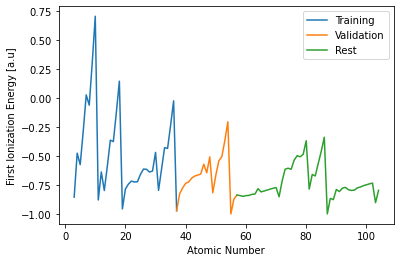

In [416]:
# Plotting the scaled Ionization Energy


plt.plot(Z[2:37],Y[2:37],label = "Training")
plt.plot(Z[36:57],Y[36:57], label = "Validation")

plt.plot(Z[56:],Y[56:], label = "Rest")

plt.xlabel("Atomic Number")
plt.ylabel("First Ionization Energy [a.u]")
plt.legend()

# a.u, arbitrary units.

- One form of validation I focused on was graphing the results. It will be easy to see by graphing how well the data has trained. In particular, I will be focussing on whether the model manages to predict the peaks and troughs of the ionization energy, as the troughs represent the noble gasses and the peaks represent the halogens. 
- I also specified as a validation set the 5th period and a few atoms more, up to Z = 56.

### Model and Training
- The loss function used was the mean squared error, this was a natural choice for a regression problem. 
- I initially began training the model with only one LSTM layer. I found, however, that the model was not managing to fit to the training data; there was not enough complexity in the model to represent the training data. I found that adding another layer signifigantly increased the convergence of the training loss. With two LSTM layers, the model was easily able to fit to the training data. The problem was, however, that the model converged easily to the training data, yet produced predictions which did not represent the rest of the data in the slightest.

Here is an example of a typical prediction:

![Prediction One](./Prection_1.png)

Along with the training and validation loss:

![Typical Prediction Loss](./Typical_Prediction_Loss.png)

- It was abundantly clear that the model was overfitting to the training data. Therefore, I added a regularization parameter. I used tensor flows inbuilt regularizer; it was sufficient to regularize the weights of the second hidden layer. I also varied the regularization parameter, starting with 0.1, and decreasing until the model was able to fit to the training data such that on the graph the training prediction looked identical to the training labels. Yet the mean squared error with the regularization did not signifigantly drop below 0.01, indicating little overfitting was occuring.

- Here I give the code of the final model:

In [426]:
# Defining the LSTM model

model2 = tf.keras.Sequential([
    tf.keras.layers.LSTM(80,return_sequences = True),
    tf.keras.layers.LSTM(80,return_sequences = True,
    kernel_regularizer=tf.keras.regularizers.L1(0.002)),
    tf.keras.layers.Dense(units = 1)
])

model2.compile(loss =tf.keras.losses.MeanSquaredError(),optimizer = "adam")




In [419]:
# Loading the trained weights 

model2.load_weights("lstm_regularized_scaled_final")

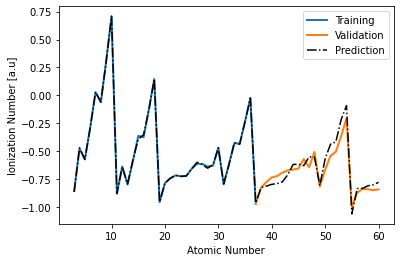

In [424]:
# I used this block to visualise the results of a model, in this case the succesful one.
# It can be used to visualize any model, after retraining the model.

plt.plot(Z[2:37],Y[2:37],linewidth = 2,label = "Training")
plt.plot(Z[36:60],Y[36:60],linewidth = 2, label = "Validation")

"""
plt.plot(X_train,y_train)
plt.plot(X_test,y_test,"-")"""
predlist = np.concatenate((X_train,X_test))

xs = np.linspace(3,60,58)
Y_pred = model2.predict(xs.reshape([1,len(xs),1]))
plt.xlabel("Atomic Number")
plt.ylabel("Ionization Number [a.u]")
plt.plot(xs,Y_pred[0,:,0],"k-.",label = "Prediction")
plt.legend()


plt.show()

### Validation:
- The model architecture and training data is very fragile. By this I mean, small changes in the initialization and further training of even the final model I produced will upset the validation results. I will mention this further in the discussion section.

- When I was validating the model I was looking at only the fifth period and a few atoms onward. The objective for this model was to predict the fifth period based on past data. I find it amazing how accurate this model has predicted the fifth period. Most importantly, the model predicts completely accurately where the peaks and troughs are in the fifth period. 

- I found it less necessary in this step to visualize the validation loss; as there were solutions which had similar validation losses (on the same order) yet did not learn the structure of the data. The focus here was to learn the structure, not simply to get the closest numerical prediction of ionization energy based on atomic number.

- To further validate the model, I let the prediction run for higher atomic numbers. After seeing that the model was innacurate past period 5, I removed the lanthanides, to see if it could accurately predict period 6.

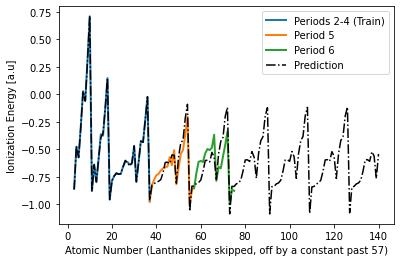

In [423]:
# Demonstrating the models prediction up to high atomic number
# The atomic numbers past 56 are innacurate ! 
plt.plot(Z[2:37],Y[2:37],linewidth = 2,label = "Periods 2-4 (Train)")
plt.plot(Z[36:57],Y[36:57],linewidth = 2, label = "Period 5")
plt.plot(Z[56:75],Y[70:89],linewidth = 2, label = "Period 6")

"""
plt.plot(X_train,y_train)
plt.plot(X_test,y_test,"-")"""
predlist = np.concatenate((X_train,X_test))

xs = np.linspace(3,140,138)
Y_pred = model2.predict(xs.reshape([1,len(xs),1]))

plt.plot(xs,Y_pred[0,:,0],"k-.",label = "Prediction")
plt.legend()

plt.xlabel("Atomic Number (Lanthanides skipped, off by a constant past 57)")
plt.ylabel("Ionization Energy [a.u]")

plt.show()


- The clear effect of the regularization parameter is that the model learns a representation of the periodicity of the data, rather than overfitting to the small dimps in the training data. It also learns to ignore (to a certain extent) the first two periods. Although, only this particular model has learnt to ignore the first two periods, other random initializations also produce periodic data which can be seen to mirror the first two periods more closely. All the models which were trained using a regularization parameter produced periodic predictions.
- The model also predicts the 6th period fairly well. Most importantly, it gets the structure correct. 
- There is an unavoidable bias here. The model is absolutely handpicked to have the best validation results. 'In the eyes of the neural network' this representation of the data is no more accurate than any other representation of the data that by a similarly trained but differently initialized model. In this sense, the result is likely not a global minima of the loss function (including regularization). It is hard even to say if the global minima corresponds to a prediction with high validation accuracy, or if the objective is even convex. 


## Discussion
- I won't say that it is a surprise that the atomic mass and ionization energy are crucial classifiers of period. We have seen by  a simple visualiation of the data that the classes are linearly separable in this feature space. It is a surprise to me, however, that the model can still predict the period of an element without the atomic mass. It seems to me that without atomic mass there is little representation in the data of atomic number. Without atomic number, classifying period becomes much harder, yet it is still doable up to a threshold accuracy of around 80%.
- I learnt more about the actual training of regression models in this exercise. In particular, I will be extremely cautious to use regression results from any small data set such as this. Even though the regression results are very accurate structurally for the 5th and 6th periods: the model and data is extremely fragile, more so than I predicted. This model is not generalizeable at all. 
- What is most interesting to me is that the model can converge to training losses which are extremely similar, yet produce entirely different predictions for latter atomic numbers. It is clearly difficult for a model to learn the trend of ionization energy, factors that cause this are likely that the number of valence electrons increases as the period increases. In this sense, the data in the first few periods is not completely representative of the data in the subsequent periods. The training results are also testament to this.
- I began working on predicting all the features based on atomic number. This is an avenue for future work, to see if the model is able to harness information from other features to aid in predicting future features. From initial results, a much more complex model would be needed, as the model was not even able to predict the atomic number; it was overfitting to all the other features.

- This exercise was more focussed on learning about the training models and the data, as opposed to producing a useful model. None of the models are generalizable or useful. The regression model is innacurate for higher atomic numbers. Classifying elements into period based on information which excludes atomic mass may be a useful property in a step towards identifying elements based on measurements without atomic mass, although this is a niche situation. Going from classifying period to classifying elements is a big jump.

### Acknowledging sources.
- I acknowledged the data sources in the dataset section.
- I got most of the ideas from discussion in the tutorial sessions from Prof Duane Loh.
- I should also mention that I got help with formatting the input data for the LSTM model from Daniel Tan, a year Three student at Australian National University. (This was about reshaping the input data)


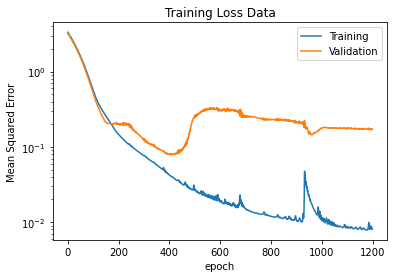

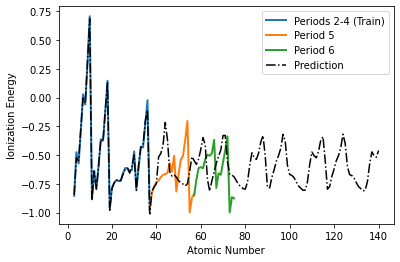

In [427]:
# This code block can run a sample validation of the model training.
# It is unlikely the model will converge to an accurate validation, 
# Yet it should converge to an accurate training loss 

store = model2.fit(inp,out,epochs = 1200,verbose = 0,validation_data = (val_inp,val_out))

#plt.plot(np.concatenate((loss,store.history['loss'])))
plt.plot(store.history['loss'],label = "Training")
plt.plot(store.history['val_loss'],label="Validation")

plt.yscale("log")
#plt.xscale("log")
plt.xlabel("epoch")
plt.ylabel("Mean Squared Error")

plt.title("Training Loss")
plt.legend()
plt.savefig("Typical_Prediction_Loss")
plt.show()


plt.plot(Z[2:37],Y[2:37],linewidth = 2,label = "Periods 2-4 (Train)")
plt.plot(Z[36:57],Y[36:57],linewidth = 2, label = "Period 5")
plt.plot(Z[56:75],Y[70:89],linewidth = 2, label = "Period 6")

"""
plt.plot(X_train,y_train)
plt.plot(X_test,y_test,"-")"""
predlist = np.concatenate((X_train,X_test))

xs = np.linspace(3,140,138)
Y_pred = model2.predict(xs.reshape([1,len(xs),1]))

plt.plot(xs,Y_pred[0,:,0],"k-.",label = "Prediction")
plt.legend()
plt.xlabel("Atomic Number")
plt.ylabel("Ionization Energy")
plt.savefig("Prection_1")

plt.show()
